# Metropolis Hastings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

## Observations

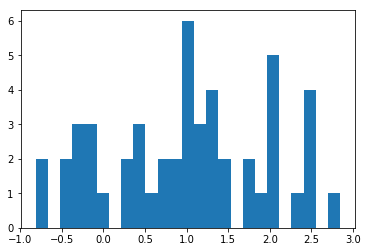

In [2]:
num_observations = 50
theta_true = 1.


N = torch.distributions.normal.Normal(theta_true, 1.)
observations = N.sample(torch.Size([num_observations])).view(-1).numpy()

plt.hist(observations, bins=25)
plt.show()

## Posterior inference with Metropolis-Hastings

In [3]:
def log_likelihood(theta, observations):
    with torch.no_grad():
        N = torch.distributions.normal.Normal(theta.item(), 1.)
        likelihood = N.log_prob(observations).sum()
        
    return likelihood

In [4]:
from hypothesis.transition import UniformTransitionDistribution

min = torch.tensor(-5)
max = torch.tensor(8)
transition = UniformTransitionDistribution(min, max)

In [5]:
from hypothesis.inference import MetropolisHastings

sampler = MetropolisHastings(log_likelihood, transition)

In [6]:
theta_0 = torch.tensor(5).float()
thetas, acceptances = sampler.infer(observations, theta_0=theta_0, samples=50000)
thetas = torch.tensor(thetas)

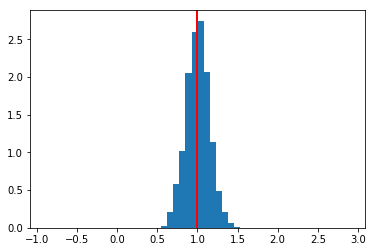

In [7]:
plt.hist(thetas.numpy(), bins=50, density=True)
plt.axvline(theta_true, c='r', lw=2)
plt.show()

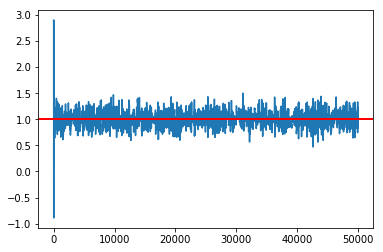

In [8]:
plt.plot(np.arange(thetas.size(0)), thetas.numpy())
plt.axhline(theta_true, c='r', lw=2)
plt.show()